In [10]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Optimization cuts

**WARNING:**

This notebook contains discontinued code and old results.
They are kept here momentarily in order to save this kind of information and reproduce it with _pyirf_ .

**Author(s):**
    
- Dr. Michele Peresano (CEA-Saclay/IRFU/DAp/LEPCHE), 2020
based on previous work by J. Lefacheur.

**Description:**

This notebook contains DL3 benchmarks about cuts optimization performed within the _protopipe_ pipeline.

**Note:**

- a more general set of benchmarks is being defined in cta-benchmarks/ctaplot,
- follow [this](https://www.overleaf.com/16933164ghbhvjtchknf) document by adding new benchmarks or proposing new ones.

## Table of contents

* [Efficiencies and angular cut as a function of energy bins](#Efficiencies-and-angular-cut-as-a-function-of-energy-bins)
* [Efficiencies and rates as a function of score](#Efficiencies-and-rates-as-a-function-of-score)

## Imports

In [11]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.table import Table, Column
from gammapy.spectrum.models import PowerLaw
from gammapy.stats import significance_on_off
from protopipe.pipeline.utils import load_config
from protopipe.perf.utils import save_obj, load_obj, plot_hist

## Functions and classes

In [12]:
class CutsDiagnostic(object):
    """
    Class used to get some diagnostic related to the optimal working point.
    Parameters
    ----------
    config: `dict`
        Configuration file
    indir: `str`
        Output directory where analysis results is located
    """
    def __init__(self, config, indir, obs_time, plots_dir, analysisName):
        self.config = config
        self.analysisName = analysisName
        self.plots_dir = plots_dir
        self.indir = indir
        self.outdir = os.path.join(indir, 'diagnostic')
        self.obs_time = obs_time
        if not os.path.exists(self.outdir):
            os.makedirs(self.outdir)
        self.table = Table.read(
            os.path.join(indir, '{}.fits'.format(config['general']['output_table_name'])),
            format='fits'
        )

        self.clf_output_bounds = self.config['column_definition']['classification_output']['range']

    def plot_optimisation_summary(self):
        """Plot efficiencies and angular cut as a function of energy bins"""
        plt.figure(figsize=(5, 5))
        ax = plt.gca()
        t = self.table[np.where(self.table['keep'].data)[0]]

        ax.plot(np.sqrt(t['emin'] * t['emax']), t['eff_sig'], color='blue', marker='o',
                label='Signal')
        ax.plot(np.sqrt(t['emin'] * t['emax']), t['eff_bkg'], color='red', marker='o',
                label='Background (p+e)')
        ax.grid(which='both')
        ax.set_xlabel('Reco energy [TeV]')
        ax.set_ylabel('Efficiencies')
        ax.set_xscale('log')
        ax.set_ylim([0., 1.1])

        ax_th = ax.twinx()
        ax_th.plot(np.sqrt(t['emin'] * t['emax']), t['angular_cut'], color='darkgreen',
                   marker='s')
        ax_th.set_ylabel('Angular cut [deg]', color='darkgreen')
        ax_th.tick_params('y', colors='darkgreen', )
        ax_th.set_ylim([0., 0.5])

        ax.legend(loc='upper left')

        plt.tight_layout()
        
        plt.savefig(f"{self.plots_dir}/cuts_efficiencies_protopipe_{self.analysisName}.png")

        return ax

    def plot_diagnostics(self):
        """Plot efficiencies and rates as a function of score"""

        for info in self.table[np.where(self.table['keep'].data)[0]]:
            obj_name = 'diagnostic_data_emin{:.3f}_emax{:.3f}.pkl.gz'.format(
                info['emin'], info['emax']
            )
            data = load_obj(os.path.join(self.outdir, obj_name))

            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
            ax_eff = axes[0]
            ax_rate = axes[1]

            ax_eff = self.plot_efficiencies_vs_score(ax_eff, data, info)
            ax_rate = self.plot_rates_vs_score(ax_rate, data, info,
                                               self.obs_time.unit)

            ax_eff.set_xlim(self.clf_output_bounds)
            ax_rate.set_xlim(self.clf_output_bounds)
            
            plt.savefig(f"{self.plots_dir}/cuts_diagnostic_{info['emin']:.2f}_{info['emax']:.2f}TeV_protopipe_{self.analysisName}.png")

            plt.tight_layout()

    @classmethod
    def plot_efficiencies_vs_score(cls, ax, data, info):
        """Plot efficiencies as a function of score"""
        ax.plot(data['score'], data['hist_eff_sig'], color='blue',
                label='Signal', lw=2)

        ax.plot(data['score'], data['hist_eff_bkg'], color='red',
                label='Background (p+e)', lw=2)

        ax.plot([info['best_cutoff'], info['best_cutoff']], [0, 1.1], ls='--', lw=2,
                color='darkgreen', label='Best cutoff')

        ax.set_xlabel('Score')
        ax.set_ylabel('Efficiencies')
        ax.set_ylim([0., 1.1])
        ax.grid(which='both')
        ax.legend(loc='lower left', framealpha=1)
        return ax

    @classmethod
    def plot_rates_vs_score(cls, ax, data, info, time_unit):
        """Plot rates as a function of score"""
        scale = info['min_flux']

        opt = {'edgecolor': 'blue', 'color': 'blue', 'label': 'Excess in ON region',
               'alpha': 0.2, 'fill': True, 'ls': '-', 'lw': 1}
        error_kw = dict(ecolor='blue', lw=1, capsize=1, capthick=1, alpha=1)
        ax = plot_hist(ax=ax, data=(data['cumul_excess'] * scale) /
                                   (info['obs_time'] * u.Unit(time_unit).to('s')),
                       edges=data['score_edges'], norm=False,
                       yerr=False, error_kw=error_kw, hist_kwargs=opt)

        opt = {'edgecolor': 'red', 'color': 'red', 'label': 'Bkg in ON region',
               'alpha': 0.2, 'fill': True, 'ls': '-', 'lw': 1}
        error_kw = dict(ecolor='red', lw=1, capsize=1, capthick=1, alpha=1)
        ax = plot_hist(ax=ax, data=data['cumul_noff'] * info['alpha'] / (info['obs_time'] * u.Unit(time_unit).to('s')),
                       edges=data['score_edges'], norm=False,
                       yerr=False, error_kw=error_kw, hist_kwargs=opt)

        ax.plot([info['best_cutoff'], info['best_cutoff']], [0, 1.1], ls='--', lw=2,
                color='darkgreen', label='Best cutoff')

        max_rate_p = (data['cumul_noff'] * info['alpha'] / (info['obs_time'] * u.Unit(time_unit).to('s'))).max()
        max_rate_g = (data['cumul_excess'] / (info['obs_time'] * u.Unit(time_unit).to('s'))).max()

        scaled_rate = max_rate_g * scale
        max_rate = scaled_rate if scaled_rate >= max_rate_p else max_rate_p

        ax.set_ylim([0., max_rate * 1.15])
        ax.set_ylabel('Rates [HZ]')
        ax.set_xlabel('Score')
        ax.grid(which='both')
        ax.legend(loc='upper right', framealpha=1)

        ax.text(
            0.52, 0.35, CutsDiagnostic.get_text(info),
            horizontalalignment='left',
            verticalalignment='bottom',
            multialignment='left',
            bbox=dict(facecolor='white', alpha=0.5),
            transform=ax.transAxes
        )
        return ax

    @classmethod
    def get_text(cls, info):
        """Returns a text summarising the optimisation result"""
        text = 'E in [{:.2f},{:.2f}] TeV\n'.format(info['emin'], info['emax'])
        text += 'Theta={:.2f} deg\n'.format(info['angular_cut'])
        text += 'Best cutoff:\n'
        text += '-min_flux={:.2f} Crab\n'.format(info['min_flux'])
        text += '-score={:.2f}\n'.format(info['best_cutoff'])
        text += '-non={:.2f}\n'.format(info['non'])
        text += '-noff={:.2f}\n'.format(info['noff'])
        text += '-alpha={:.2f}\n'.format(info['alpha'])
        text += '-excess={:.2f}'.format(info['excess'])
        if info['systematic'] is True:
            text += '(syst.!)\n'
        else:
            text += '\n'
        text += '-nbkg={:.2f}\n'.format(info['background'])
        text += '-sigma={:.2f} (Li & Ma)'.format(info['sigma'])

        return text

## Input

In [13]:
parentDir = ""
analysisName = ""
obs_time = ""
DL3_output = f"irf_tail_ThSq_opti_Time{obs_time}"

In [14]:
indir = os.path.join(parentDir, "shared_folder/analyses", analysisName, "data/DL3", DL3_output)
infile = "table_best_cutoff.fits"
config_file = os.path.join(parentDir, "shared_folder/analyses", analysisName, "configs", "performance.yaml")

## Setup

In [15]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
Path("./plots").mkdir(parents=True, exist_ok=True)
# Read configuration file
cfg = load_config(config_file)
# Cuts diagnostic
print('### Building cut diagnostics...')
cut_diagnostic = CutsDiagnostic(config=cfg, 
                                indir=indir, 
                                obs_time = 50 * u.h, 
                                plots_dir = "./plots", 
                                analysisName = analysisName)

### Building cut diagnostics...


## Benchmarks

### Efficiencies and angular cut as a function of energy bins
[back to top](#Table-of-contents)

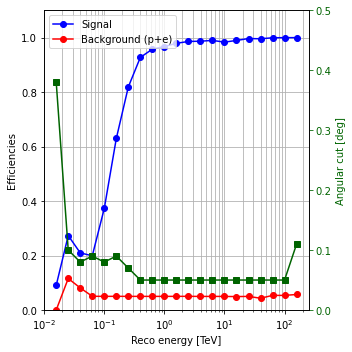

In [16]:
cut_diagnostic.plot_optimisation_summary()
plt.show()

### Efficiencies and rates as a function of score
[back to top](#Table-of-contents)

/Users/michele/Applications/miniconda3/envs/protopipe/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


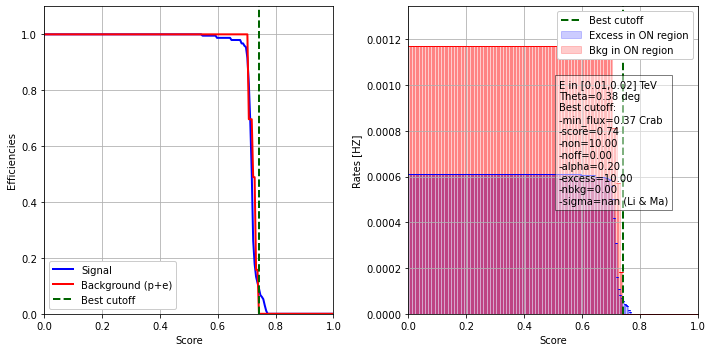

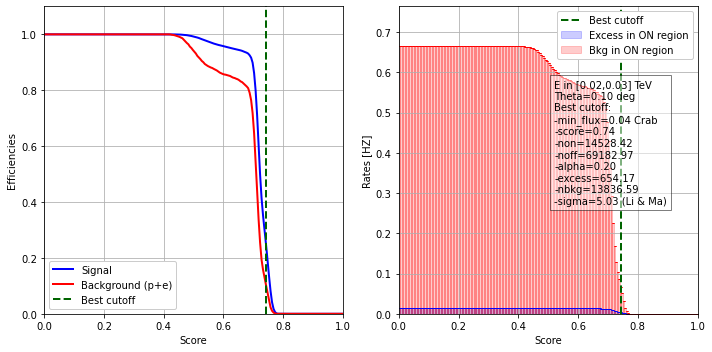

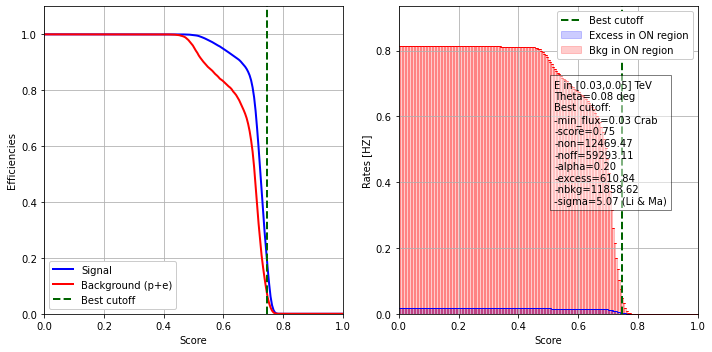

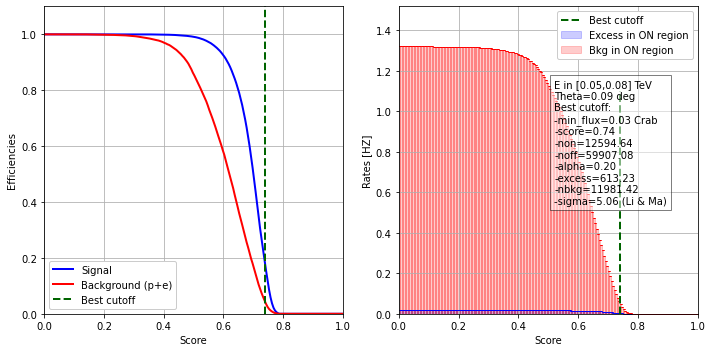

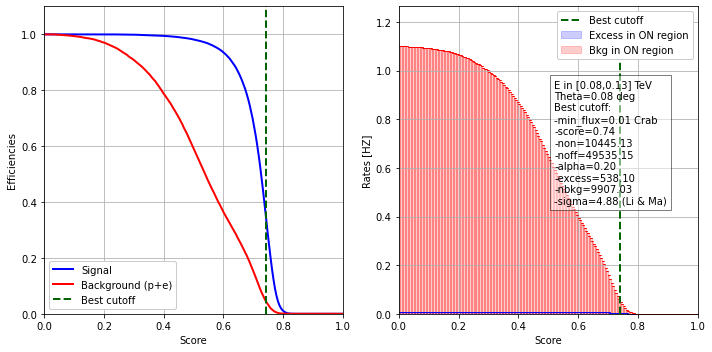

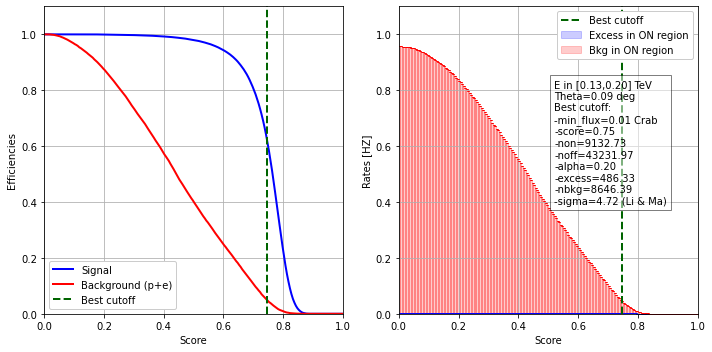

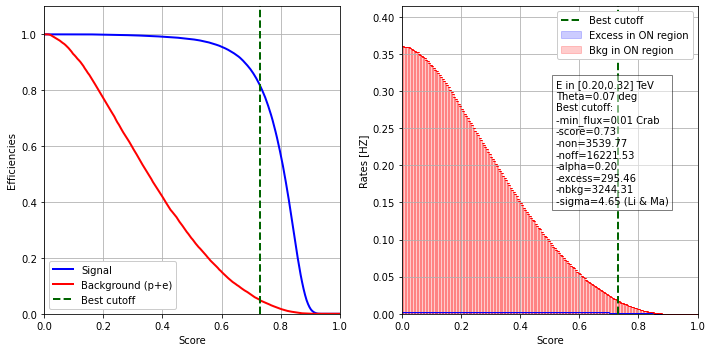

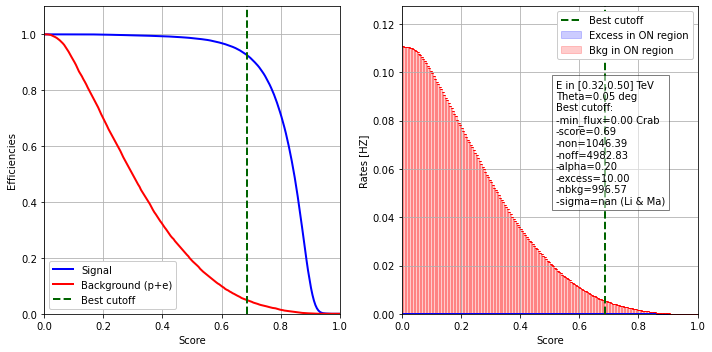

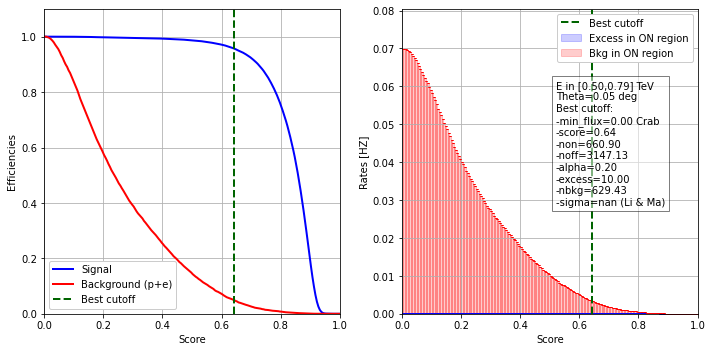

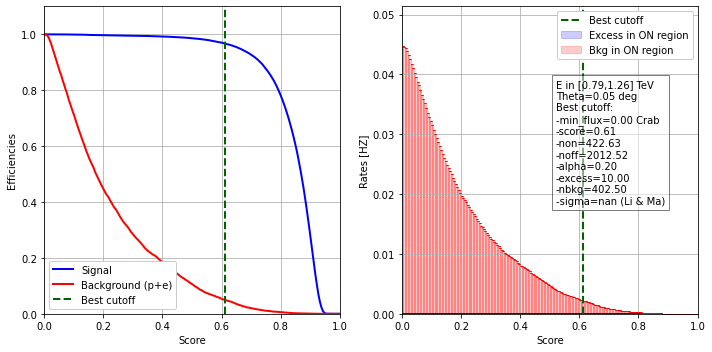

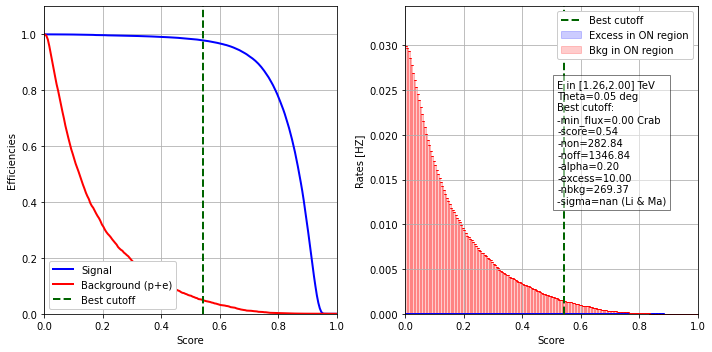

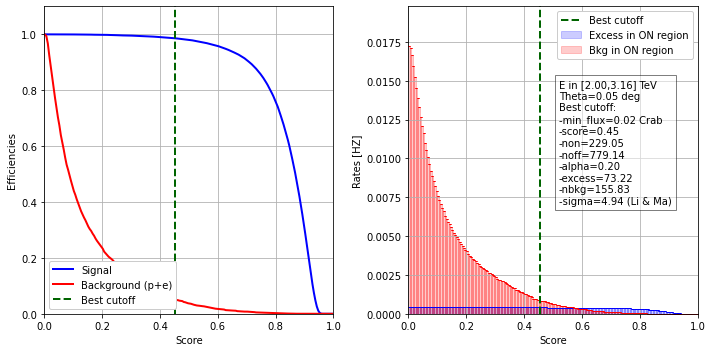

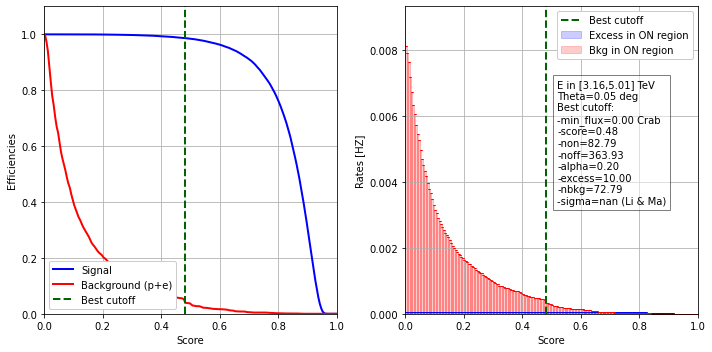

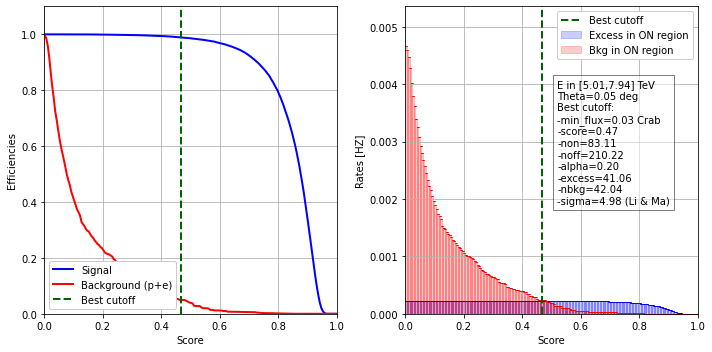

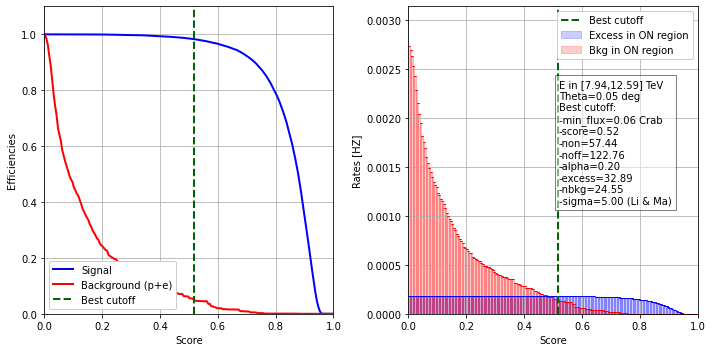

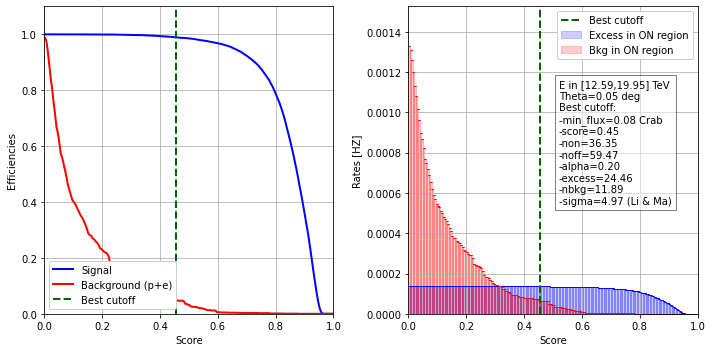

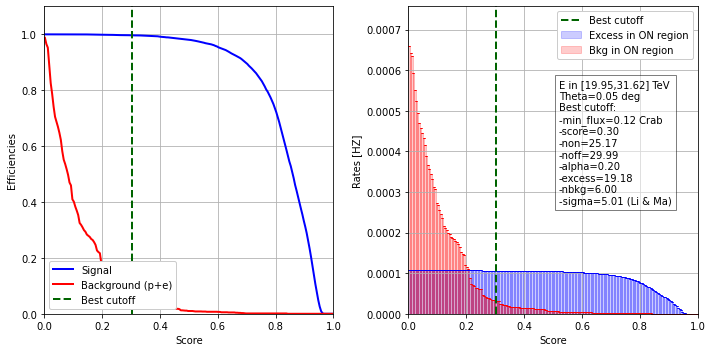

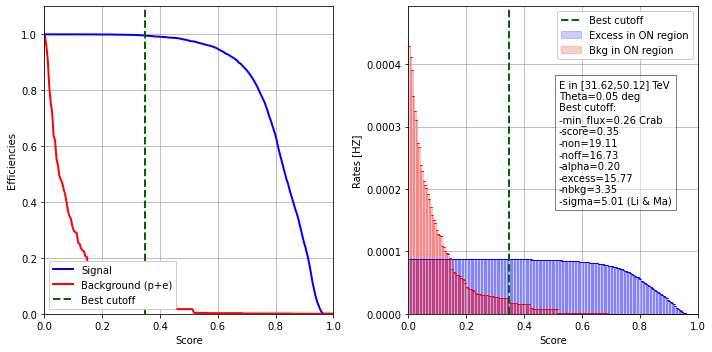

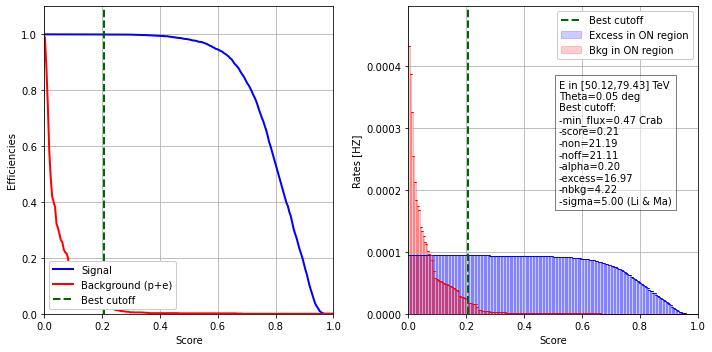

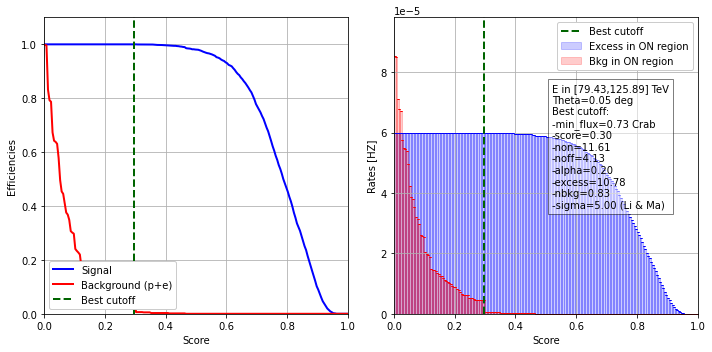

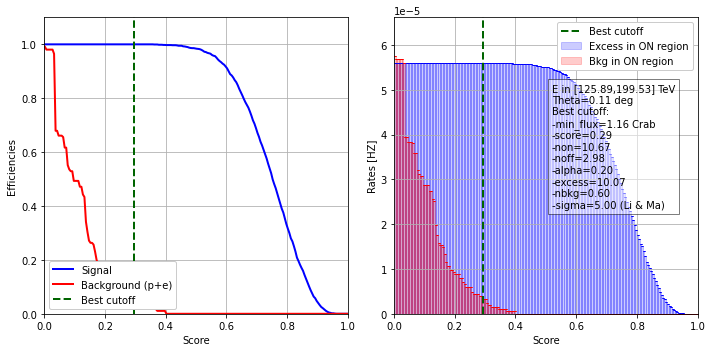

In [17]:
cut_diagnostic.plot_diagnostics()